In [34]:
from __future__ import absolute_import, division, print_function, unicode_literals

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display


import tensorflow as tf

In [35]:
(train_images, train_labels), (_,_) = tf.keras.datasets.mnist.load_data()

train_images.shape
train_labels.shape

(60000,)

In [36]:
train_images = train_images.reshape(train_images.shape[0], 28,28,1).astype('float32')
train_images.shape

(60000, 28, 28, 1)

In [37]:
#Normalizacion de las imagenes
train_images = (train_images - 127.5)/127.5

BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [38]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

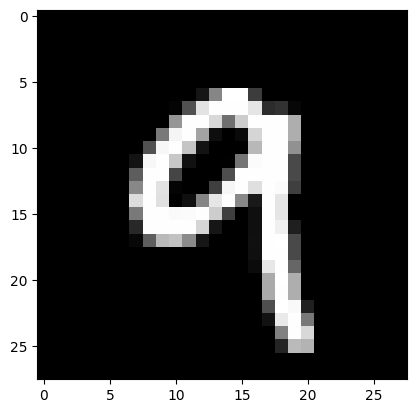

In [39]:
#Visualizacion de set de datos

plt.imshow(train_images[110].reshape((28,28)), cmap = 'gray')

In [40]:
#Creando Generador

    #El generador toma una señal de ruido aleatorio y emite imágenes.
    #El generador trata de generar imágenes falsas que son similares a las reales (las que provienen de los datos de entrenamiento)
    #El objetivo del generador es engañar al discriminador.
    #Las etiquetas están marcadas de la siguiente manera:
        #a etiqueta = 1.0 indica imágenes reales
        #La etiqueta = 0.0 indica imágenes falsas
    #El generador utiliza tf.keras.layers.Conv2DTranspose (upsampling) capas para crear una imagen a partir de una semilla de ruido.
    #La semilla se alimenta a una capa densa y se submuestrea varias veces hasta que se alcanza el tamaño final de la imagen de 28x28x1.

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,))) # 12544
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))

    # Debido a que usamos el "mismo" relleno y zancada / strides = 1, la salida es del mismo tamaño que la entrada 7 x 7 pero con 128 filtros en su lugar
    # Resultando en 7 x 7 x 128
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)) 
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Debido a que usamos el "mismo" relleno y zancada / strides = 2, la salida es el doble del tamaño de la entrada 14 x 14 pero con 64 filtros en su lugar
    # Resultando en 14 x 14 x 64
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Debido a que usamos el "mismo" relleno y zancada / zancadas = 2, la salida es el doble del tamaño de la entrada 28 x 28 pero con 1 filtro en su lugar
    # Resultando en 28 x 28 x 1
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    model.summary()

    return model

In [41]:
#Probamos el generador
generator = make_generator_model()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

In [42]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 28, 28, 1])

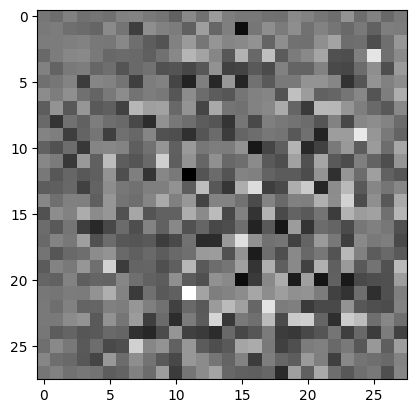

In [43]:
plt.imshow(generated_image[0,:,:,0], cmap='gray')

In [44]:
#Creando Discriminador

    #El discriminador es una red neuronal básica que está entrenada para realizar tareas de clasificación.
    #El discriminador está entrenado para hacer lo siguiente:
    #Salida 0 (probabilidad = 0%) cuando la imagen de entrada es falsa
    # Salida 1 (probabilidad = 100%) cuando la imagen de entrada es real

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    model.summary()

    return model

In [45]:
#Definimos el discriminador
discriminator = make_discriminator_model()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
# Observamos si el discriminador fue capaz de clasificar la imagen o no! 
# El modelo será entrenado para producir valores positivos para imágenes reales, y valores negativos para imágenes falsas.

decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00019771]], shape=(1, 1), dtype=float32)


In [47]:
# Funcion de Perdida para Generador / Discriminador

# Esto calcula la "pérdida" que simplemente la diferencia entre las predicciones del modelo y la etiqueta verdadera
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# La pérdida del discriminador indica lo bien que el discriminador es capaz de distinguir imágenes reales y falsas. 
# Compara las predicciones del discriminador sobre las imágenes reales con una serie de 1s, 
# y las predicciones del discriminador sobre las imágenes falsas (generadas) a un conjunto de 0s.
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss # sum up both losses
    return total_loss

In [48]:
# La pérdida del generador cuantifica lo bien que fue capaz de engañar al discriminador. 
# Si el generador funciona bien, el discriminador clasificará las imágenes falsas como reales (o 1). 
# Aquí, compararemos las decisiones del discriminador sobre las imágenes generadas con un conjunto de 1s.

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [49]:
#Creamos el optimizador Adam
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


#Creamos un checkpoint para la red
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [50]:
#Entrenamiento
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])


In [51]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True) # Paso 1. Llamar al generador y alimentar la semilla del ruido

      real_output = discriminator(images, training=True) # Paso 2. Pasar los falsos y los verdaderos al discriminador para realizar la clasificación
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output) # paso 3. Calcular la pérdida para el generador y el discriminador
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) # paso 4. calcular el gradiente de las pérdidas
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) # paso 5. Aplicar los optimizadores y actualizar los pesos
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [52]:
#Funcion de entrenamiento
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Producir imágenes para el GIF sobre la marcha
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Guardar el modelo cada 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generar luego del epoch final
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [53]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


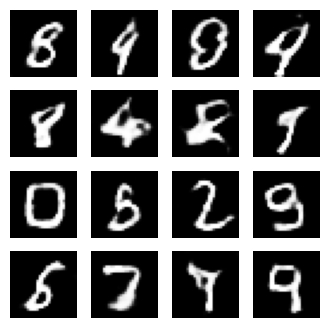

Time for epoch 79 is 220.9299213886261 sec


In [ ]:

train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Mostrar una sola imagen usando el número de Epoch
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS)